# Chorus effect project

## Introduction

In this notebook, we present an implementation of a chorus effect that takes an input signal and outputs the sum of several copies of the input signal, each with a differently varying pitch. First, a pitch shifting algorithm is proposed. Then, we will implement a time-varying pitch shift, and use it to create several modified copies of an original signal in order to implement a chorus effect.

The purpose of a chorus effect is to create the illusion that the same sound is played simultaneously by several sources. The pitch variations have to be small enough so that the modified sources don't sound out of tune. 

## Investigating the Audio

To begin, let's import the useful packages, read the original file and plot its time and frequency domain representations.

#### Import packages

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
from IPython.display import Image

#### Read original file

In [2]:
fs, signal = wavfile.read("singing_8000.wav")
print('Sampling rate :', fs, 'Hz')
print("Original WAV:")
IPython.display.Audio(signal, rate = fs)

Sampling rate : 8000 Hz
Original WAV:


#### Plot time domain waveform

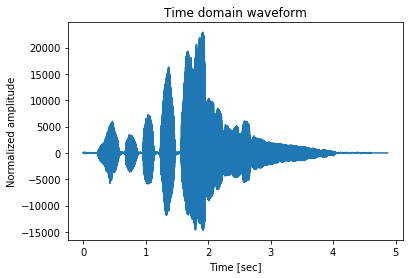

In [3]:
t = np.arange(len(signal))/fs
plt.title('Time domain waveform')
plt.xlabel('Time [sec]')
plt.ylabel('Normalized amplitude')
plt.plot(t,signal)
plt.show()

We notice that the signal is composed of multiple consecutives notes, followed by a long sustained note. This is a good example for a chorus effect, since it is has periodic and harmonic content. This kind of sounds may be tricky to handle, since changing their pitch can introduce artifacts.

#### Plot spectrogram

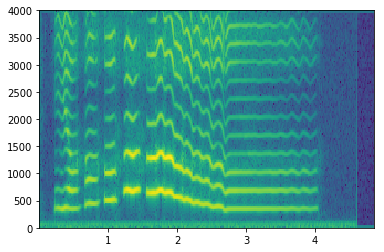

In [4]:
plt.specgram(signal, NFFT=256, Fs =fs);

The previous spectrogram confirms the presence of multiple notes as depicted earlier, and allows us to observe the different harmonic content of the signal.

##  Constant pitch shift - Naive method

A first method simply consists of applying a constant delay in the frequency domain.

In [5]:
def freqDelay(signal, fshift, fs):
    
    shift = int(fshift/fs*len(signal));
    signal_fft = np.fft.rfft(signal);
    signal_fft_rolled = np.roll(signal_fft, shift);
    signal_fft_rolled[0:shift] = 0;
    signal_pitched = np.fft.irfft(signal_fft_rolled)
    
    return signal_pitched

#### Shifted signal

The shifted signal using this simple trick sounds a bit "robotic", as you can hear below. This is due to the fact that by shifting the whole spectrum, we also move the overall envelope.

In [6]:
shifted_signal = freqDelay(signal, 200, fs);
IPython.display.Audio(shifted_signal, rate = fs)

#### Sum of pitch-shifted and original signal

The sum of the original signal with the pitch-shifted version creates beats. For this reason, it is not a good method for creating a chorus effect. 

The spectrograms for both signal can be seen below.

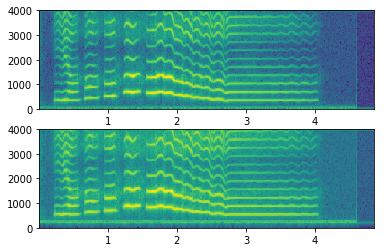

In [7]:
plt.subplot(2, 1, 1)
plt.specgram(signal, NFFT=256, Fs =fs);
plt.subplot(2, 1, 2)
plt.specgram(freqDelay(signal, 200, fs), NFFT=256, Fs =fs);


And here a sum of both original and shifted signals can be heard:

In [8]:
signals_summed = signal[0:len(shifted_signal)] + shifted_signal;
IPython.display.Audio(signals_summed, rate = fs)

This doesn't sound really natural, but we decided to implement it as a funny voice transformation tool in our app !

#### Changing sampling frequency

One way to change the pitch without creating artifacts is to change the sampling frequency of the signal. This results in a pitch shift, but also a time-stretching, which is unwanted for a chorus effect, where the two sounds should have the same duration. Thus, we need to time scale the transformed signal in order for it to have the same duration as the original one.

Here is the result of the signal when we simply change its sampling frequency :

In [9]:
IPython.display.Audio(signal, rate = fs*1.5)

## Constant pitch shift using Phase Vocoder

In order to pitch shift, we can therefore use a time stretching algorithm which will give a longer or a shorter version of the signal, according to a factor alpha (where $\alpha = L_1 / L_0$, where $L_1$ is the length of time stretched signal and $L_0$ the length of the original signal). 

We implemented a time-scaling algorithm called Phase Vocoder presented in [1]. The main idea is to decompose the original signal in overlapping frames, and re-arrange them using a hopsize scaled by a factor $\alpha$. The picture below [1] depicts this procedure, for an analysis hopsize of length $H_a$ and synthesis hopsize of length $H_s$. If no special care is taken, this basic procedure will introduce distortion due to the sound periodic content (which is predominant in harmonic signals).



![title](TSM.png)

Therefore, we implemented the Phase Vocoder algorithm, which tackles this problem by modifying the Fourier transforms of the frames, in order to have horizontal phase coherence in between frames. However, this will destroy vertical phase coherence, and thus is not optimal for sounds containing transients, typically percussive instruments. 

Since a chorus effect is usually applied to harmonic sounds (e.g. voice, guitar, violin...), this algorithm is particularly suited for our design, as opposed to the basic OLA algorithm which performs better with percursive components.

Below is the time-stretch implementation:

In [10]:
def time_stretch(signal,alpha):
    '''
    Time stretch signal by a factor alpha. 
    Output will have length alpha times length of the signal.
    '''
    N = int(2**7) 									#frame size
    Hs= int(2**7/8) 								#Synthesis hopsize
    Ha = int(Hs / float(alpha)) 					#Analysis hopsize
    w = np.hanning(2**7) 							#Hanning window
    wscale = sum([i**2 for i in w]) / float(Hs)		#Scaling factor
    L0 = signal.size								#original signal size
    L1 = int(signal.size*alpha)						#output signal size
    
    # Initialization
    signal = np.append(np.zeros(int(len(w))), signal)
    
    time_stretch_signal = np.zeros(int((signal.size)*alpha + signal.size/Ha * alpha))
    idx_synthesis = 0
    idx_analysis = 0
    i = 0
    
    # Loop over frames
    while idx_synthesis <= signal.size - (Hs+N):
        i += 1
        # Get Fourier transform of two consecutive windowed frames    
        X = np.fft.fft(w*signal[idx_synthesis:idx_synthesis+N])
        Xnew = np.fft.fft(w*signal[idx_synthesis+Hs:idx_synthesis+Hs+N])

        if idx_synthesis == 0:
            # First frame is not modified
            Xmod_new = Xnew 

        else:
            # Adapt phase to avoid phase jumps. Xmod contains the modified spectrum of previous frame and 
            # Xmod_new contains the spectrum of the frame we are modifying.
            phi =  np.angle(Xmod) + np.angle(Xnew) - np.angle(X)
            Xmod_new = abs(Xnew) * np.exp(1j*phi)

        #Update parameters
        Xmod = Xmod_new
        time_stretch_signal[idx_analysis:idx_analysis+N] = np.add(time_stretch_signal[idx_analysis:idx_analysis+N], np.real(w*np.fft.ifft(Xmod_new)), 
                                                                  out=time_stretch_signal[idx_analysis:idx_analysis+N], casting="unsafe")
        idx_synthesis = int(idx_synthesis+Ha)		# analysis hop
        idx_analysis += Hs							# synthesis hop

    #Scale and remove tails
    time_stretch_signal = time_stretch_signal / wscale 
    time_stretch_signal = np.delete(time_stretch_signal, range(Hs))
    time_stretch_signal = np.delete(time_stretch_signal, range(L1, time_stretch_signal.size))

    return time_stretch_signal


Here is what we obtain when time-stretching the original signal by a factor 2:

In [11]:
alpha = 2
pitched_signal = time_stretch(signal,alpha)
IPython.display.Audio(pitched_signal, rate = fs)

It works to speed up the signal:

In [12]:
alpha = 0.5
pitched_signal = time_stretch(signal,alpha)
IPython.display.Audio(pitched_signal, rate = fs)

To obtain a constant pitch shift, we only need to resample the time stretched signal by a factor alpha:

In [13]:
alpha = 2
pitched_signal = time_stretch(signal,alpha)
pitched_signal_resample = sp.signal.resample(pitched_signal,len(signal))
IPython.display.Audio(pitched_signal_resample, rate = fs)

And to pitch down:


In [14]:
alpha = 0.5
pitched_signal = time_stretch(signal,alpha)
pitched_signal_resample = sp.signal.resample(pitched_signal,len(signal))
IPython.display.Audio(pitched_signal_resample, rate = fs)

Here we go! We have a clean, pitched version of our original signal. The last step is to make this pitch vary in time.

## Time varying pitch shift

In order to get a time-varying pitch, we send different windowed frames with different values of alpha to the phase vocoder, resample them, and sum them in order to recover the pitched-varying signal. The diagram and corresponding code can be seen below:

![title](timevarying.png)

In [15]:
def time_varying_pitch(signal, fs, intensity, rate):
    '''
    Apply a time varying pitch on signal. 
    Pitch is modulated by a sinusoidal of rate and intensity defined by user.
    '''
    
    #Define parameters according to intensity and rate
    N = int(rate*len(signal)/fs)								#Number of periods of the modulation sine
    overlap = 400												#Overlap size for reconstruction
    safety = 200												#Safety padding length to avoid artifacts at frame beginning
    effective_window = 1000										#Effective frame length
    length_window = effective_window + overlap + 2*safety		#Total frame length (i.e. with padding and overlap)
    n = int(len(signal)/effective_window)						#Number of frames
    fade_in = np.linspace(0,1,overlap)							#Triangle window
    fade_out = np.linspace(1,0,overlap)							#Triangle window
    time_stretch_resample = []									#Empty vector to fill with result
    window_resample = []										#Empty vector to fill with current window result
    delay = 2**6												#Delay applied on the result
    
    #Loop over frames
    for i in range(n):
        
        #Evaluate current value of alpha
        alpha = 1 + intensity*np.sin(2*N*np.pi*i/n)
        
        #Apply time stretch on window
        low_index = i*effective_window
        high_index = i*effective_window + length_window
        time_stretched_window = time_stretch(signal[low_index:high_index],alpha)

        #Delete safety margins
        time_stretched_window = np.delete(time_stretched_window,range(len(time_stretched_window)-int(safety*alpha),len(time_stretched_window)))
        time_stretched_window = np.delete(time_stretched_window,range(0,int(safety*alpha)))
            
        
        #Resample the time stretched audio to get pitch shift, and overlap them
        window_resample = sp.signal.resample(time_stretched_window,effective_window+overlap)
        if i==0:
            time_stretch_resample = window_resample
            #fade out
            time_stretch_resample[effective_window:effective_window+overlap] *= fade_out

        if i>0:
            # fade in - fade out
            window_resample[0:overlap] *= fade_in
            window_resample[effective_window:effective_window+overlap] *= fade_out
            time_stretch_resample[len(time_stretch_resample)-overlap:len(time_stretch_resample)] += window_resample[0:overlap]
            time_stretch_resample = np.append(time_stretch_resample,window_resample[overlap:])
            
    time_stretch_resample = np.append(signal[0:safety-delay],time_stretch_resample)
    return time_stretch_resample
    

Let's see what we get when we sum the original signal and a signal whose pitch varies at 1Hz, with a pitch variation of ±2%. 

In [16]:
pitched_signal = time_varying_pitch(signal,fs,0.02,1)
IPython.display.Audio(signal[0:min(len(pitched_signal),len(signal))]+pitched_signal[0:min(len(pitched_signal),len(signal))], rate = fs)


## Chorus Effect

Now, we have every required tools in order to apply a chorus effect ! We just need to design it. We decided that the user can set two sinusoidal modulations, i.e. 4 parameters, plus a mix parameter (wet), which goes from 0 (only original signal) to 1 (only pitch varying signals). The user should typically choose an intensity between 0 and 0.1, and a rate between 0 and 10 Hz for natural sounding results. In the application, the user can change the spatial location of each time-varying pitch signals. We recommend to set one of the two on the left and the other one on the right to improve spatial impression.

In [17]:
def chorus_effect(signal, fs, intensity1, intensity2, rate1, rate2, wet):
    '''
    Apply a chorus effect on signal, return signal with chorus
    '''
    chorus_signal_1 = time_varying_pitch(signal,fs,intensity1,rate1)
    chorus_signal_2 = time_varying_pitch(signal,fs,intensity2,rate2)
    
    return 1/2*wet*chorus_signal_1[0:min(len(chorus_signal_1),len(signal))]+1/2*wet*chorus_signal_2[0:min(len(chorus_signal_1),len(signal))]+ (1-wet)*signal[0:min(len(chorus_signal_1),len(signal))]


Here is a mono example with predefined settings:

In [18]:
chorus = chorus_effect(signal,fs,0.025,0.015,0.9,2.0,0.7)
IPython.display.Audio(chorus,rate = fs)

## Conclusion

The main challenge of this project was to find a reliable method to change the pitch of the signal without creating artifacts such as "clicking" noises or undeisred robotic effect.

In this report, we proposed a way to implement a chorus effect via Python. We decided to use a time scaling approach, and more precisely a Phase Vocoder. This application could be made more robust to a wide variety of sound by seperating percussive and harmonic content of a signal, and apply different methods for each, respectively OLA and Phase Vocoder.

## References

[1] Driedger, Jonathan and Meinard Müller. “A Review of Time-Scale Modification of Music Signals †.” (2016).

[2] Dan Ellis. "Lecture 9: Time & Pitch Scaling", Dept. Electrical Engineering, Columbia University, (2013).

[3] Paolo Prandoni. "Voice Transformers", EPFL, GitHub, (2018).